In [22]:
from pathlib import Path
import napari
from skimage import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import skimage
from sklearn.metrics import confusion_matrix
import pickle
import h5py
from tqdm.notebook import tqdm
import networkx as nx


from cell_paint_seg.utils import (
    get_id_to_path,
    get_id_from_name_96,
    combine_soma_cell_labels,
    combine_soma_nucleus_labels,
    check_valid_labels,
)

In [5]:
data_dir = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw")
cp_order = {1:"ER",2:"DNA",3:"Actin",4:"RNA",5:"Golgi"}
antibody_order = {1: "DAPI", 3: "NeuN"}

In [16]:
def AP2(seg1, seg2, iou_threshold=0.5):
    """Computes the AP2 score between two segmentations.

    Args:
        seg1 (np.array): first instance segmentation. 0 is background.
        seg2 (np.array): second instance segmentation. 0 is background.
        iou_threshold (float, optional): iou threshold. Defaults to 0.5.
    """

    def iou_score(seg1, seg2):
        intersection = np.logical_and(seg1, seg2).sum()
        union = np.logical_or(seg1, seg2).sum()
        return intersection / union

    # construct a networkx graph that has a vertex for each connected component in seg1 and seg2
    nodes = [(0, i) for i in np.unique(seg1) if i != 0] + [
        (1, i) for i in np.unique(seg2) if i != 0
    ]
    G = nx.Graph()
    G.add_nodes_from(nodes)

    # add edges between nodes with an iou greater than the threshold
    for i in tqdm(np.unique(seg1), desc="Constructing graph", leave=False):
        if i == 0:
            continue
        for j in np.unique(seg2[seg1 == i]):
            if j == 0:
                continue
            iou = iou_score(seg1 == i, seg2 == j)
            if iou > iou_threshold:
                G.add_edge((0, i), (1, j), weight=1)
                if iou_threshold > 0.5:
                    break

    # find the maximum weight matching
    matching = nx.max_weight_matching(G)

    # calculate the AP score
    tp = len(matching)
    fp = len(np.unique(seg1)) - 1 - tp
    fn = len(np.unique(seg2)) - 1 - tp
    ap2 = tp / (tp + fp + fn)

    return ap2

# NeuN

## View

In [3]:
# list all tifs in the data directory
tif_files = list(data_dir.glob("*.tif"))

im_paths = {}

for tif in tif_files:
    name = tif.stem 

    id = name.split("_")[-1].split("c")[0]

    if "antibody" in name:
        c = int(name[-1]) + 5
    else:
        c = int(name[-1])
        
    if id not in im_paths.keys():
        im_paths[id] = {c: tif}

    else:
        cur_dict = im_paths[id]
        cur_dict[c] = tif
        im_paths[id] = cur_dict
im_paths

{'s32': {5: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s32c5.tif'),
  4: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s32c4.tif'),
  3: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s32c3.tif'),
  2: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s32c2.tif'),
  1: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s32c1.tif'),
  8: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/antibody__s32c3.tif'),
  6: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/antibody__s32c1.tif')},
 's34': {3: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/raw/Cell_Paint__s3

In [15]:
key = 's19'#list(paths.keys())[0]

viewer = napari.Viewer()

for c in paths[key].keys():
    im = io.imread(paths[key][c])
    viewer.add_image(im, name=f"Channel: {c}")

## View reg

In [4]:
# list all tifs in the data directory
data_dir_reg = data_dir.parent / "tifs_for_reg"
tif_files = list(data_dir_reg.glob("*.tif"))

reg_paths = {}

for tif in tif_files:
    name = tif.stem 


    if "antibody" in name:
        id = name.split("_")[-1].split("c")[0]
        c = int(name[-1]) + 5
    elif "reg" in name:
        id = "s" + name.split("_")[0]
        c = 9
    else:
        id = name.split("_")[-1].split("c")[0]
        c = int(name[-1])
        
    if id not in reg_paths.keys():
        reg_paths[id] = {c: tif}

    else:
        cur_dict = reg_paths[id]
        cur_dict[c] = tif
        reg_paths[id] = cur_dict
reg_paths

{'s32': {5: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/Cell_Paint__s32c5.tif'),
  4: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/Cell_Paint__s32c4.tif'),
  3: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/Cell_Paint__s32c3.tif'),
  2: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/Cell_Paint__s32c2.tif'),
  1: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/Cell_Paint__s32c1.tif'),
  9: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/32_reg.tif'),
  8: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tifs_for_reg/antibody__s32c3.tif'),
  6: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/dat

In [5]:
key = 's19'#list(paths.keys())[0]

viewer = napari.Viewer()

for c in paths[key].keys():
    im = io.imread(paths[key][c])
    viewer.add_image(im, name=f"Channel: {c}")

## View seg

In [5]:
# list all tifs in the data directory
data_dir_reg = data_dir.parent / "tommy/segmentations"
tif_files = list(data_dir_reg.glob("*.tif"))

seg_paths = {}

for tif in tif_files:
    name = tif.stem 


    id = name.split("_")[-1].split("c")[0]
    c = int(name.split("c")[-1].split(".")[0])
        
    if id not in seg_paths.keys():
        seg_paths[id] = {c: tif}

    else:
        cur_dict = seg_paths[id]
        cur_dict[c] = tif
        seg_paths[id] = cur_dict
seg_paths

{'s35': {13: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c13.tif'),
  12: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c12.tif'),
  10: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c10.tif'),
  11: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c11.tif'),
  15: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c15.tif'),
  14: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c14.tif'),
  7: PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/data/aneesh/2025_04_nuc-stains/tommy/segmentations/Cell_Paint__s35c7.t

In [8]:
key = 's19'#list(paths.keys())[0]

viewer = napari.Viewer()

for c in paths[key].keys():
    im = io.imread(paths[key][c])
    viewer.add_image(im, name=f"Channel: {c}")

## Stats

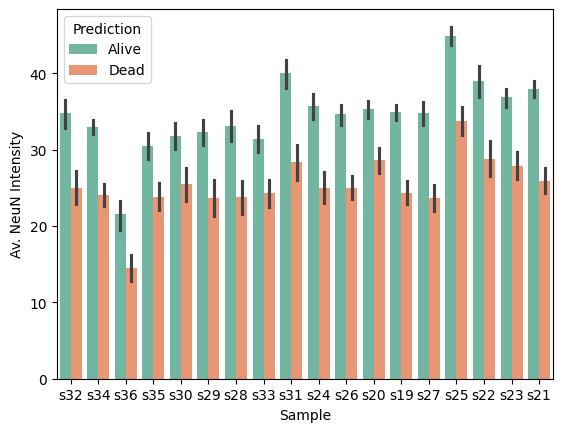

In [19]:
data_neun = []
data_class = []
data_sample = []

for key in im_paths.keys():
    im_dna = io.imread(im_paths[key][2])
    im_neun = io.imread(reg_paths[key][9])
    im_seg_all = io.imread(seg_paths[key][9])
    im_seg_alive = io.imread(seg_paths[key][12])
    im_seg_dead = io.imread(seg_paths[key][15])

    for id in np.unique(im_seg_alive):
        if id == 0:
            continue
        mask = im_seg_alive == id
        data_neun.append(np.mean(im_neun[mask]))
        data_class.append("Alive")
        data_sample.append(key)

    for id in np.unique(im_seg_dead):
        if id == 0:
            continue
        mask = im_seg_dead == id
        data_neun.append(np.mean(im_neun[mask]))
        data_class.append("Dead")
        data_sample.append(key)

data = {"Prediction": data_class,
        "Av. NeuN Intensity": data_neun,
        "Sample": data_sample}

df = pd.DataFrame(data)
sns.barplot(x="Sample", y="Av. NeuN Intensity", hue="Prediction", data=df, palette="Set2")

plt.savefig("neun_intensity.png")

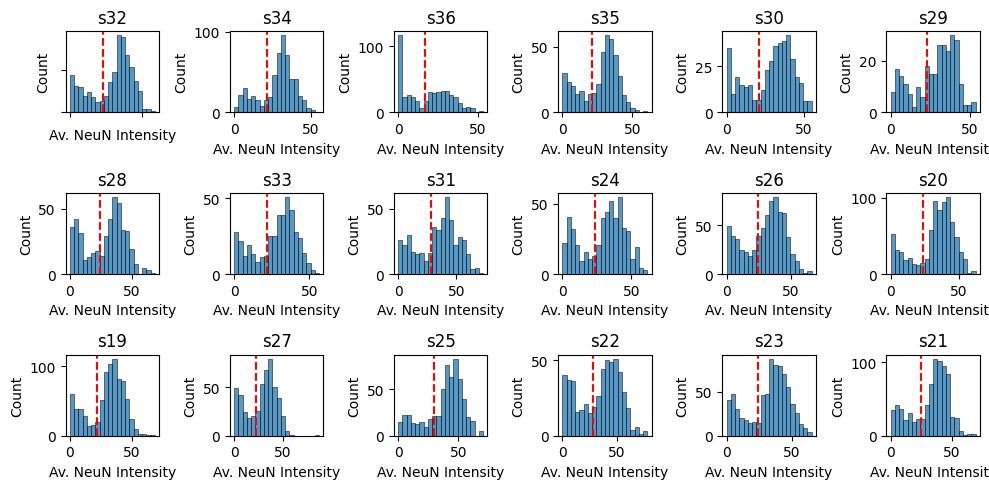

In [27]:
data_neun = []
data_sample = []

f, axs = plt.subplots(3, 6, figsize=(10, 5))

for i, (key, ax) in enumerate(zip(im_paths.keys(), axs.flatten())):
    im_dna = io.imread(im_paths[key][2])
    im_neun = io.imread(reg_paths[key][9])
    im_seg_all = io.imread(seg_paths[key][9])
    im_seg_alive = io.imread(seg_paths[key][12])
    im_seg_dead = io.imread(seg_paths[key][15])

    neuns = []
    for id in np.unique(im_seg_all):
        if id == 0:
            continue
        mask = im_seg_all == id
        neuns.append(np.mean(im_neun[mask]))
        data_sample.append(key)

    data_neun += neuns

    threshold = skimage.filters.threshold_otsu(np.array(neuns))

    df = pd.DataFrame({"Av. NeuN Intensity": neuns})
    sns.histplot(df, x="Av. NeuN Intensity", ax=ax, bins=20)
    ax.set_title(key)
    # plot a vertical line at the threshold
    ax.axvline(threshold, color='r', linestyle='--')

    if i == 0:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Av. NeuN Intensity")
        ax.set_ylabel("Count")


plt.tight_layout()
plt.savefig("neun_intensity_hist.png")

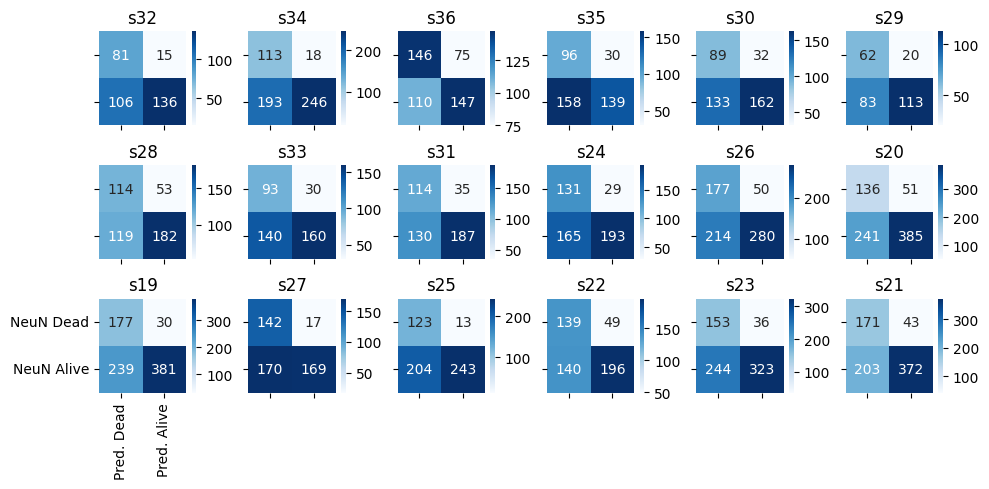

In [30]:
data_neun = []
data_pred = []
data_sample = []
data_gt = []

f, axs = plt.subplots(3, 6, figsize=(10, 5))

for i, (key, ax) in enumerate(zip(im_paths.keys(), axs.flatten())):
    im_dna = io.imread(im_paths[key][2])
    im_neun = io.imread(reg_paths[key][9])
    im_seg_all = io.imread(seg_paths[key][9])
    im_seg_alive = io.imread(seg_paths[key][12])
    im_seg_dead = io.imread(seg_paths[key][15])

    neuns = []
    preds = []
    for id in np.unique(im_seg_alive):
        if id == 0:
            continue
        mask = im_seg_alive == id
        neuns.append(np.mean(im_neun[mask]))
        preds.append(1)
        data_sample.append(key)

    for id in np.unique(im_seg_dead):
        if id == 0:
            continue
        mask = im_seg_dead == id
        neuns.append(np.mean(im_neun[mask]))
        preds.append(0)
        data_sample.append(key)

    # use otsu's method to find the threshold of avgs
    threshold = skimage.filters.threshold_otsu(np.array(neuns))

    gts = [0 if n < threshold else 1 for n in neuns]

    data_gt += gts
    data_pred += preds
    data_neun += neuns

    cm = confusion_matrix(gts, preds)

    # plot heat map of confusion matrix
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Pred. Dead", "Pred. Alive"],
                yticklabels=["NeuN Dead", "NeuN Alive"],
                ax=ax)
    ax.set_title(key)
    
    if i != 12:
        # turn off x and y tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()
plt.savefig("neun_intensity_confusion.png")


In [46]:
for i, (key, ax) in enumerate(zip(im_paths.keys(), axs.flatten())):
    if i >= 3:
        print(i, key)
        break
    im_dna = io.imread(im_paths[key][2])
    im_neun = io.imread(reg_paths[key][9])
    im_seg_all = io.imread(seg_paths[key][9])
    im_seg_alive = io.imread(seg_paths[key][12])
    im_seg_dead = io.imread(seg_paths[key][15])

    neuns = []
    for id in np.unique(im_seg_all):
        if id == 0:
            continue
        mask = im_seg_all == id
        neuns.append(np.mean(im_neun[mask]))

    # use otsu's method to find the threshold of avgs
    threshold = skimage.filters.threshold_otsu(np.array(neuns))

    im_seg_neun = np.zeros_like(im_seg_alive)
    im_seg_dead_neun = np.zeros_like(im_seg_dead)

    for id in np.unique(im_seg_all):
        if id == 0:
            continue
        mask = im_seg_all == id
        av = np.mean(im_neun[mask])
        if av < threshold:
            im_seg_neun[mask] = 1
        else:
            im_seg_neun[mask] = 2


    im_seg_pred = np.zeros_like(im_seg_alive)
    im_seg_pred[im_seg_dead > 0] = 1
    im_seg_pred[im_seg_alive > 0] = 2

    seg_class = np.zeros_like(im_seg_alive)
    seg_class[(im_seg_pred == 1) & (im_seg_neun == 1)] = 1
    seg_class[(im_seg_pred == 1) & (im_seg_neun == 2)] = 2
    seg_class[(im_seg_pred == 2) & (im_seg_neun == 1)] = 3

    viewer = napari.Viewer()
    viewer.add_image(np.amax(im_dna, axis=-1), name=f"DNA - {key}")
    viewer.add_image(np.amax(im_neun, axis=-1), name="NeuN")
    viewer.add_labels(seg_class, name="NeuN vs. Pred.", colormap={1:(0,1,0,1), 2:(1,0,0,1), 3:(0,0,1,1)})



/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/napari/utils/colormaps/colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/napari/utils/colormaps/colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


3 s35


/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/napari/utils/colormaps/colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


# Manual GT

In [49]:
path_im = (
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/hdf5s/"
)

path_seg_gt = (
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v3/"
)
path_seg_pred = "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/segmentations/"

path_ctype_gt = "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v3/celltypes/"
path_ctype_pred = (
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/hdf5s/"
)

id_to_path_seg_gt = get_id_to_path(
    path_seg_gt, tag=".tif", id_from_name_nchar=4
)
id_to_path_seg_pred = get_id_to_path(
    path_seg_pred, tag=".tif", id_from_name_nchar=4
)

id_to_path_ctype_gt = get_id_to_path(
    path_ctype_gt, tag=".pickle", id_from_name_nchar=4
)
id_to_path_ctype_pred = get_id_to_path(
    path_ctype_pred, tag="Predictions_gt.h5", id_from_name_nchar=4
)

In [52]:
f_ctype_pred

PosixPath('/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/hdf5s/s039_Object Predictions_gt.h5')

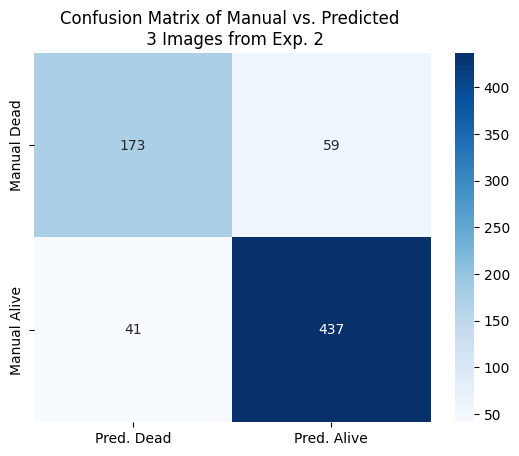

In [66]:
data_acc = []
data_ious = []
data_celltype = []
data_sample = []

data_acc_05 = []
data_celltype_05 = []
data_sample_05 = []

cms = []
for sample in id_to_path_seg_gt.keys():
    f_seg_gt = id_to_path_seg_gt[sample][2]
    f_seg_pred = id_to_path_seg_pred[sample][1]

    f_ctype_gt = id_to_path_ctype_gt[sample]
    f_ctype_pred = id_to_path_ctype_pred[sample]

    seg_pred = io.imread(f_seg_pred)
    seg_gt = io.imread(f_seg_gt)

    # gt
    with open(f_ctype_gt, "rb") as f:
        types = pickle.load(f)
    # for each entry in types, if the first element is not equal to sample, delete it
    types = [i for i in types if i[0] == sample]
    obj_to_type_gt = {i[1]: int(i[2]) for i in types}
    obj_to_type_gt[0] = 3

    assert set(obj_to_type_gt.keys()) == set(np.unique(seg_gt))

    seg_gt_alive = np.zeros_like(seg_gt)
    seg_gt_dead = np.zeros_like(seg_gt)
    for obj, ctype in obj_to_type_gt.items():
        if ctype == 1:
            seg_gt_alive[seg_gt == obj] = seg_gt[seg_gt == obj]
        if ctype == 2:
            seg_gt_dead[seg_gt == obj] = seg_gt[seg_gt == obj]

    # predicted
    with h5py.File(f_ctype_pred, "r") as f:
        obj_type = np.squeeze(f["exported_data"][:])

    obj_to_type_pred = {}
    for obj in np.unique(seg_gt):
        loc = np.argwhere(seg_gt == obj)[0, :]
        obj_to_type_pred[obj] = obj_type[loc[0], loc[1]]

    assert set(obj_to_type_pred.keys()) == set(np.unique(seg_gt))

    gt_vector = []
    pred_vector = []
    for obj, ctype in obj_to_type_pred.items():
        if obj == 0:
            continue

        if obj in obj_to_type_gt.keys():
            gt_vector.append(obj_to_type_gt[obj])
            pred_vector.append(ctype)

    gt_vector = np.array(gt_vector)
    pred_vector = np.array(pred_vector)

    cm = confusion_matrix(gt_vector, pred_vector)
    cms.append(cm)

cm_total = np.sum(cms, axis=0)
# use seaborn to plot heatmap of cm_total
# reverse the order of both axes of cm_total
cm_total = cm_total[::-1, ::-1]
sns.heatmap(cm_total,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred. Dead", "Pred. Alive"],
            yticklabels=["Manual Dead", "Manual Alive"])
plt.title("Confusion Matrix of Manual vs. Predicted \n 3 Images from Exp. 2")
plt.savefig("manual_confusion.png")
